In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import heapq
from io import StringIO

# ==============================================================================
# 1. CHUẨN BỊ DỮ LIỆU (Giữ nguyên)
# ==============================================================================
file_content = """IdStart	IdEnd	Length
0	19	50.0
0	4	50.7
1	20	23.5
2	1	26.5
3	20	33.8
4	7	49.3
5	6	39.8
6	7	50.0
7	8	48.1
7	23	45.0
8	22	51.9
9	10	25.4
10	24	19.1
11	12	22.9
12	13	29.0
13	14	44.5
14	15	26.5
15	18	100.0
16	9	109.0
17	11	77.2
18	2	200.0
19	21	50.0
19	5	60.2
20	0	50.0
21	16	46.5
22	18	100.0
23	3	4.0
24	22	100.0
24	17	100.0
"""
df = pd.read_csv(StringIO(file_content), sep='\t')
G = nx.from_pandas_edgelist(df, source='IdStart', target='IdEnd', edge_attr='Length')
for u, v in G.edges(): G[u][v]['weight'] = G[u][v]['Length']
pos = nx.spring_layout(G, seed=30, k=0.5)

# Lấy tất cả điểm làm dữ liệu
data_points = list(G.nodes())

In [3]:
# ==============================================================================
# 2. CÀI ĐẶT LẠI LOGIC ĐỂ PHÂN LOẠI (CORE/BORDER/NOISE)
# ==============================================================================

def analyze_and_visualize_clusters(G, data_points, eps, min_pts, pos):
    
    # --- BƯỚC 1: TÍNH MẬT ĐỘ (ALGO 1 & 2) ---
    neighbors_cache = {}
    
    # Hàm tìm hàng xóm nhanh
    def get_neighbors(start_node):
        distances = {start_node: 0}
        queue = [(0, start_node)]
        nbrs = []
        while queue:
            d, u = heapq.heappop(queue)
            if d > eps: continue
            nbrs.append(u)
            for v in G.neighbors(u):
                new_d = d + G[u][v]['weight']
                if new_d <= eps and new_d < distances.get(v, float('inf')):
                    distances[v] = new_d
                    heapq.heappush(queue, (new_d, v))
        return nbrs

    # Tính cho tất cả
    for p in data_points:
        neighbors_cache[p] = get_neighbors(p)
        
    # Sắp xếp (Algo 2)
    ordered_points = sorted(data_points, key=lambda x: len(neighbors_cache[x]), reverse=True)
    
    # --- BƯỚC 2: GOM CỤM & GÁN VAI TRÒ (ALGO 3) ---
    labels = {}      # {Node: ClusterID}
    node_roles = {}  # {Node: 'Core'/'Border'/'Noise'}
    cluster_id = 0
    NOISE = -1
    
    # Logic Algo 3 gốc
    for p in ordered_points:
        if p in labels: continue
            
        p_neighbors = neighbors_cache[p]
        
        # Nếu không đủ mật độ -> Tạm gọi là Noise
        if len(p_neighbors) < min_pts:
            labels[p] = NOISE
            node_roles[p] = 'Noise'
        else:
            # Đủ mật độ -> Đây là CORE POINT (Lõi)
            cluster_id += 1
            labels[p] = cluster_id
            node_roles[p] = 'Core'
            
            # Mở rộng
            seeds = list(p_neighbors)
            while seeds:
                q = seeds.pop(0)
                q_neighbors = neighbors_cache[q]
                
                # Kiểm tra q có phải Core không?
                is_q_core = len(q_neighbors) >= min_pts
                
                if q in labels:
                    if labels[q] == NOISE:
                        labels[q] = cluster_id
                        # Trước là Noise, giờ được Core kéo vào -> Nó là BORDER (Biên)
                        # (Trừ khi chính nó cũng đủ điều kiện làm Core)
                        node_roles[q] = 'Core' if is_q_core else 'Border'
                else:
                    labels[q] = cluster_id
                    node_roles[q] = 'Core' if is_q_core else 'Border'
                    
                    if is_q_core:
                        seeds.extend(q_neighbors)

    # --- BƯỚC 3: VẼ TRỰC QUAN HÓA ---
    plt.figure(figsize=(14, 10))
    
    # 1. Vẽ nền
    nx.draw_networkx_edges(G, pos, edge_color='#DDDDDD', width=1)
    
    # 2. Tách danh sách để vẽ riêng
    core_nodes = [n for n, r in node_roles.items() if r == 'Core']
    border_nodes = [n for n, r in node_roles.items() if r == 'Border']
    noise_nodes = [n for n, r in node_roles.items() if r == 'Noise']
    
    # Lấy màu theo cụm
    def get_color(n):
        cid = labels[n]
        if cid == NOISE: return 'black'
        return plt.cm.tab10(cid)

    # 3. Vẽ NOISE (Dấu X màu đen)
    if noise_nodes:
        nx.draw_networkx_nodes(G, pos, nodelist=noise_nodes, 
                               node_color='black', node_shape='x', node_size=100, label='Nhiễu (Noise)')
        
    # 4. Vẽ CORE POINTS (Ngôi sao lớn)
    if core_nodes:
        colors = [get_color(n) for n in core_nodes]
        nx.draw_networkx_nodes(G, pos, nodelist=core_nodes, 
                               node_color=colors, node_shape='*', node_size=500, edgecolors='black', label='Điểm Lõi (Core)')
        
    # 5. Vẽ BORDER POINTS (Hình tròn nhỏ)
    if border_nodes:
        colors = [get_color(n) for n in border_nodes]
        nx.draw_networkx_nodes(G, pos, nodelist=border_nodes, 
                               node_color=colors, node_shape='o', node_size=150, edgecolors='black', label='Điểm Biên (Border)')

    # 6. Nhãn
    nx.draw_networkx_labels(G, pos, font_size=9, font_weight='bold')
    
    # 7. Vẽ viền bao quanh cụm (Convex Hull giả lập bằng cách tô màu vùng)
    # (Tùy chọn nâng cao, ở đây dùng màu node để phân biệt là đủ rõ)

    plt.title(f"KẾT QUẢ THUẬT TOÁN 3: PHÂN LOẠI & GOM CỤM\n(Eps={eps}, MinPts={min_pts})", fontsize=15)
    
    # Tạo chú thích thủ công để dễ hiểu
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='*', color='w', markerfacecolor='gray', markersize=15, label='Điểm Lõi (Core) - Đủ mật độ'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10, label='Điểm Biên (Border) - Thiếu mật độ nhưng gần Lõi'),
        Line2D([0], [0], marker='x', color='black', linestyle='None', markersize=10, label='Nhiễu (Noise) - Cô lập'),
    ]
    plt.legend(handles=legend_elements, loc='upper right')
    
    plt.axis('off')
    plt.show()
    
    # In báo cáo text
    print("\n--- BÁO CÁO PHÂN LOẠI ĐIỂM ---")
    print(f"Tổng số điểm: {len(data_points)}")
    print(f"- Số lượng Core Points: {len(core_nodes)} {core_nodes}")
    print(f"- Số lượng Border Points: {len(border_nodes)} {border_nodes}")
    print(f"- Số lượng Noise: {len(noise_nodes)} {noise_nodes}")

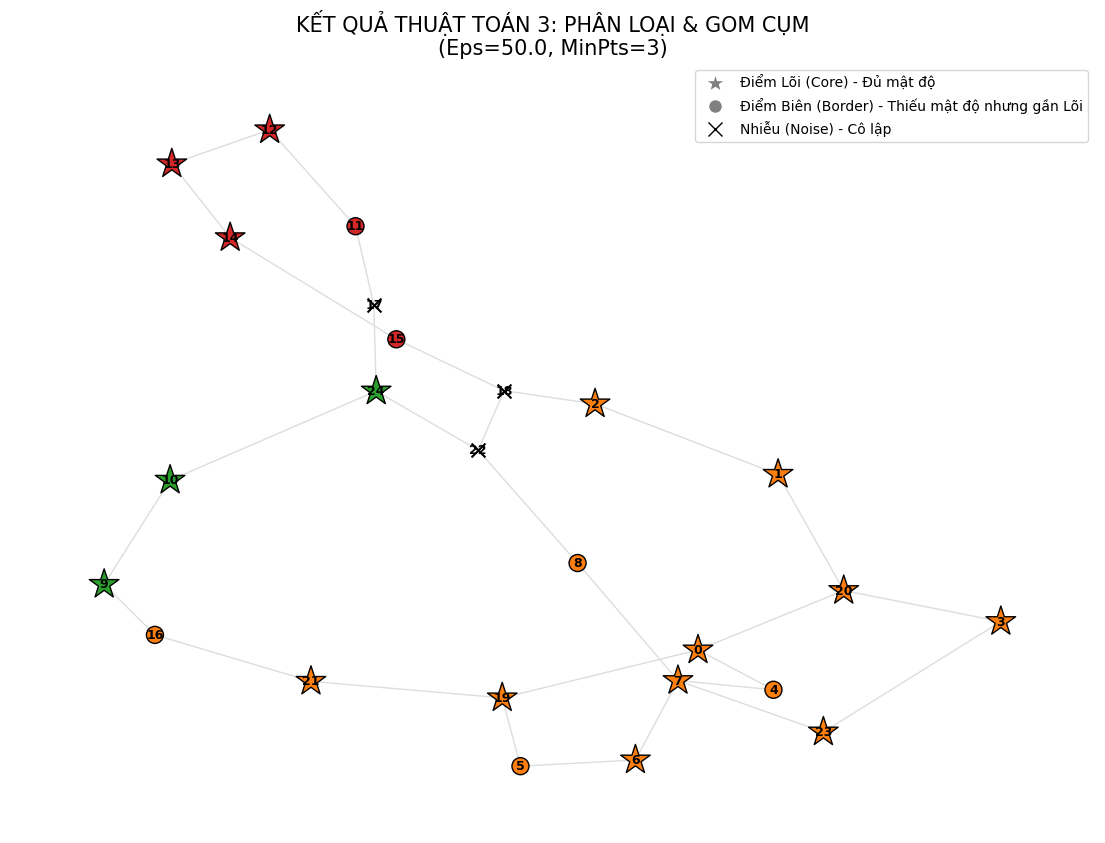


--- BÁO CÁO PHÂN LOẠI ĐIỂM ---
Tổng số điểm: 25
- Số lượng Core Points: 16 [20, 1, 3, 23, 0, 2, 7, 19, 6, 21, 9, 10, 24, 12, 13, 14]
- Số lượng Border Points: 6 [8, 4, 5, 16, 11, 15]
- Số lượng Noise: 3 [22, 18, 17]


In [4]:
# ==============================================================================
# 3. CHẠY THỬ NGHIỆM
# ==============================================================================

# Dùng Eps=50, MinPts=3
# Điều này có nghĩa là: Một điểm phải có ít nhất 3 hàng xóm (tính cả nó) trong bán kính 50 thì mới được làm Lãnh đạo (Core).
analyze_and_visualize_clusters(G, data_points, eps=50.0, min_pts=3, pos=pos)